# Where should I live? An analysis of areas in major UK cities

## Applied Data Science Capstone Project – The Battle of Neighbourhoods

### Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)
* [Appendices](#appendices)

In [1]:
"""install the necessary packages"""
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json 
from pandas.io.json import json_normalize
import numpy as np
#!conda install -c conda-forge geopy --yes
pd.set_option("display.precision", 3)
pd.options.mode.chained_assignment = None  # default='warn'
 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #package for using dates in axes of graphs
import matplotlib.cbook as cbook #general bunch of useful stuff
from matplotlib.pyplot import cm #colormaps
import matplotlib.colors as colors
mpl.style.use('seaborn-poster')
%matplotlib notebook
%matplotlib inline
from ipywidgets import *
import ipywidgets as widgets
from IPython.display import display

import seaborn as sns
import re
import requests
from sklearn import preprocessing

### Introduction <a name="introduction"></a>

It is well known that it is becoming increasingly difficult to afford a house in the UK. This is particularly noticeable in southern cities such as Oxford (my current hometown), where the cost of living has been driven up significantly above the national average by a number of factors. Part of the reason that these places are desirable are the easy access to venues such as museums, cafes and restaurants, and nature reserves. 

#### Problem:
Where could someone move that would offer a similar lifestyle to their current location?
In this project, we will try find similar areas across the UK based on access to venues, and then compare the cost of housing in these areas.

This will allow people who are unable to afford to buy a house in their current area to identify similar areas around the country that might be more affordable.

#### Target Audience:
Young people seeking to step onto the property ladder.

### Data <a name="data"></a>

In order to address this problem, we need to:

1. Identify regions we are interested in 
2. Find house prices in each of these regions
3. Find data on venues in each of these regions

#### Identify regions we are interested in 
To limit the amount of data we are working with, we have chosen to look at the following cities:

* Birmingham 
* Bristol
* Cardiff
* Leeds
* Liverpool
* London
* Manchester
* Milton Keynes
* Newcastle
* Oxford
* York

These have a wide spread across the UK while still having reasonably sized populations, and so should be reasonably comparable. Scottish cities have unfortunately been excluded as they are absent from our price dataset, as described below.

#### Find house prices in each of these regions

House price data were obtained from the [UK Land registry](https://landregistry.data.gov.uk/app/ppd), using a SPARQL query that can be found in [Appendix 1](#App1). While requests were attempted for Edinburgh and Glasgow, Scotland was not included in this dataset.

The parameters for the request were to find all house transactions from January 1 2018 to February 22 2020 in each city. Only freeholds were considered.

The separate data requests were combined in Excel and exported as a CSV file.

*In this section, we explore the price dataset.*

In [2]:
data='House_price_data.csv'
df = pd.read_csv(data)
df.head()

,unique_id,price_paid,deed_date,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,Unnamed: 16,Unnamed: 17
0,7C2D0700-8627-4963-E053-6B04A8C07B97,460000,19/11/2018,OX1 1JS,T,N,F,NaN,7,WOODBINE PLACE,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
1,919FEC05-A036-9A90-E053-6C04A8C0A300,432000,01/08/2019,OX1 1RP,T,N,F,NaN,5,BLACKFRIARS ROAD,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
2,773788C3-0BFB-2CE4-E053-6C04A8C05E57,435000,03/08/2018,OX1 1SU,T,N,F,NaN,66,THAMES STREET,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
3,75050A85-8A51-9A88-E053-6B04A8C02390,680000,24/08/2018,OX1 1SU,T,N,F,NaN,74,THAMES STREET,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN
4,75050A85-8A53-9A88-E053-6B04A8C02390,485000,27/07/2018,OX1 1SU,T,N,F,NaN,78,THAMES STREET,NaN,OXFORD,OXFORD,OXFORDSHIRE,A,http://landregistry.data.gov.uk/data/ppi/trans...,NaN,NaN


Let's tidy this up a bit - we will first remove the columns that we are not interested in, remove missing data and then make sure that they are all the correct data type

In [3]:
#removes columns we are not interested in
df = df.drop(['unique_id','saon','paon','locality','transaction_category','linked_data_uri','Unnamed: 16','Unnamed: 17'],axis=1) 
#remove blank values for price and postcode (our key data)
df = df.dropna(axis=0,subset=['price_paid','postcode']) 
print (df.shape)
df.tail()

(140969, 10)


,price_paid,deed_date,postcode,property_type,new_build,estate_type,street,town,district,county
140979,230000,23/11/2018,L9 9HZ,D,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140980,190000,25/01/2019,L9 9HZ,D,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140981,150000,16/05/2019,L9 9HZ,S,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140982,145000,20/09/2019,L9 9HZ,D,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE
140983,144000,11/05/2018,L9 9JA,S,N,F,BARLOWS LANE,LIVERPOOL,LIVERPOOL,MERSEYSIDE


In [4]:
df.dtypes

price_paid        int64
deed_date        object
postcode         object
property_type    object
new_build        object
estate_type      object
street           object
town             object
district         object
county           object
dtype: object

We can see that 'deed_date' is marked as an object, rather than as a date, so let's fix that.

In [5]:
df[["deed_date"]] = df[["deed_date"]].astype("datetime64[ns]") #convert date to correct format
df.dtypes

price_paid                int64
deed_date        datetime64[ns]
postcode                 object
property_type            object
new_build                object
estate_type              object
street                   object
town                     object
district                 object
county                   object
dtype: object

In [6]:
df.town.unique()

array(['OXFORD', 'LONDON', 'MANCHESTER', 'MILTON KEYNES',
       'NEWCASTLE UPON TYNE', 'NEWCASTLE', 'NEWCASTLE EMLYN', 'YORK',
       'BIRMINGHAM', 'BRISTOL', 'CARDIFF', 'LEEDS', 'LIVERPOOL'],
      dtype=object)

We can see that the search for 'Newcastle' found 2 additional towns which share a name with the town we are interested in (Newcastle upon Tyne), so let's get rid of those too.

In [7]:
df = df[df.town != 'NEWCASTLE']
df = df[df.town != 'NEWCASTLE EMLYN']
df.shape

(138755, 10)

In [8]:
df.describe()

,price_paid
count,1.388e+05
mean,4.114e+05
std,6.136e+05
min,5.000e+02
25%,1.730e+05
50%,2.645e+05
75%,4.450e+05
max,3.850e+07


From this, we can see that the mean house price over this period was £411,400, with a standard deviation of £613,600! There is a lot of variation in this dataset - however, this is likely skewed by the exorbitant house prices in London, and the purpose is after all to provide alternatives to expensive areas

Now, we want to generate a new column that contains only the postcode district, e.g. OX1. We will have to use a regular expression for this as the number of letters and digits is not consistent.

<img src="https://www.getthedata.com/images/postcode_format.png" alt="UK postcode information" width="400"/> 

Image and regex from https://www.getthedata.com/postcode

In [9]:
def outcode(x):
    return re.findall(r"^(((([A-Z][A-Z]{0,1})[0-9][A-Z0-9]{0,1}) {0,}[0-9])[A-Z]{2})$",x)[0][2] #this reg ex returns a list containing a single tuple with the full code, sector, district and area, so we select the appropriate parts
def postcode_area(x):
    return re.findall(r"^(((([A-Z][A-Z]{0,1})[0-9][A-Z0-9]{0,1}) {0,}[0-9])[A-Z]{2})$",x)[0][3]

df["outcode"] = df["postcode"].apply(outcode)
df['postcode_area'] = df['postcode'].apply(postcode_area)

Let's also divide the price_paid column by 1000 to make it a little easier to understand

In [10]:
df['price_paid'] = df['price_paid']/1000
df.head()

,price_paid,deed_date,postcode,property_type,new_build,estate_type,street,town,district,county,outcode,postcode_area
0,460.0,2018-11-19,OX1 1JS,T,N,F,WOODBINE PLACE,OXFORD,OXFORD,OXFORDSHIRE,OX1,OX
1,432.0,2019-01-08,OX1 1RP,T,N,F,BLACKFRIARS ROAD,OXFORD,OXFORD,OXFORDSHIRE,OX1,OX
2,435.0,2018-03-08,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1,OX
3,680.0,2018-08-24,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1,OX
4,485.0,2018-07-27,OX1 1SU,T,N,F,THAMES STREET,OXFORD,OXFORD,OXFORDSHIRE,OX1,OX


We have imported data from January 1 2018 to the present day. We should examine the data to check if there have been any major variations in house price over the period we are looking at.

In [11]:
df_time = df.sort_values(['deed_date'])
df_time = df_time.drop(['postcode','property_type','new_build','estate_type','street','district','county'],axis=1)
print(df_time.shape)
df_time.head()

(138755, 5)


,price_paid,deed_date,town,outcode,postcode_area
94374,239.995,2018-01-01,BRISTOL,BS30,BS
134737,221.000,2018-01-01,LIVERPOOL,L25,L
34680,395.000,2018-01-01,MANCHESTER,M21,M
54633,234.950,2018-01-02,NEWCASTLE UPON TYNE,NE27,NE
25885,715.000,2018-01-02,LONDON,SW18,SW


Now, let's add a moving average column, over 30 day periods, and remove the entries at the beginning and end.

In [12]:
df_ma = df_time.copy()
df_ma.set_index('deed_date', inplace = True)
df_ma['MA'] = df_ma.price_paid.rolling('30d').mean()
df_ma = df_ma.dropna(axis=0,subset=['MA'])
# print(df_ma.dtypes)
df_ma.head()

,price_paid,town,outcode,postcode_area,MA
deed_date,,,,,
2018-01-01,239.995,BRISTOL,BS30,BS,239.995
2018-01-01,221.000,LIVERPOOL,L25,L,230.498
2018-01-01,395.000,MANCHESTER,M21,M,285.332
2018-01-02,234.950,NEWCASTLE UPON TYNE,NE27,NE,272.736
2018-01-02,715.000,LONDON,SW18,SW,361.189


And let's plot the data and have a look!
#### Figure 1 <a name = "fig1"></a>

C:\Users\Jacob\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


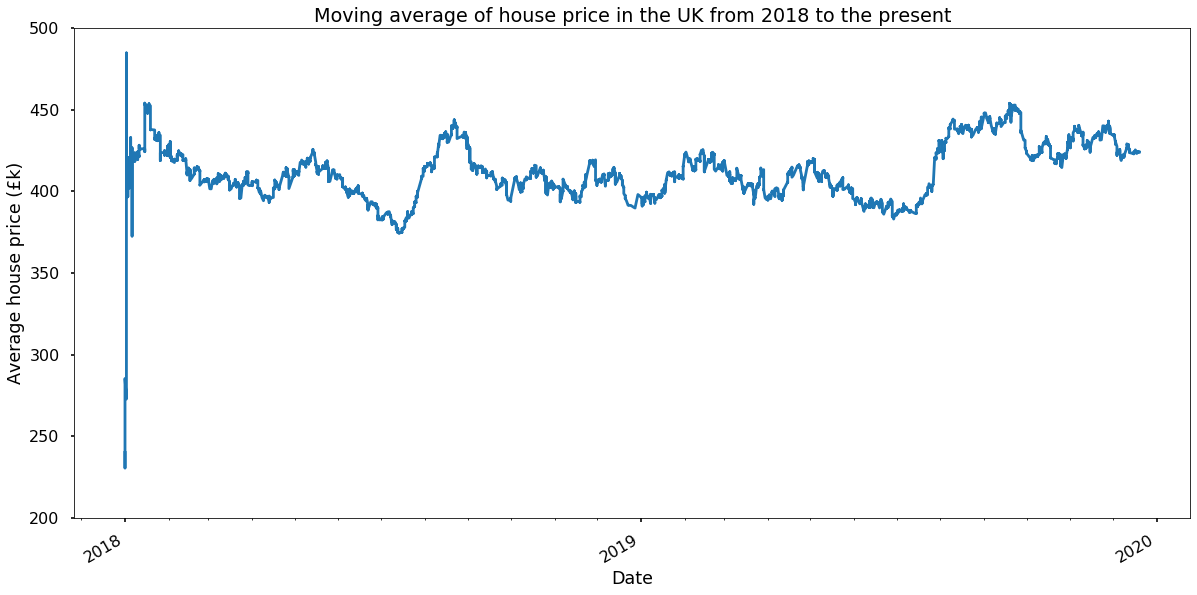

In [13]:
years = mdates.YearLocator()   # setting up dates as axis
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ma.index.values,df_ma['MA'])
ax.set(xlabel='Date',
       ylabel='Average house price (£k)',
       title='Moving average of house price in the UK from 2018 to the present',
       ylim=(200,500)
      )

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

fig.autofmt_xdate()

# fig.savefig("Figure1.png")
plt.show()

We can see a spike around August/September of 2019 but otherwise the fluctuation doesn't seem to be that large. The large spike at Jan 2018 is an artifact due to the moving average operation.

Let's compare our cities over this time.

#### Figure 2 <a name = "fig2"></a>

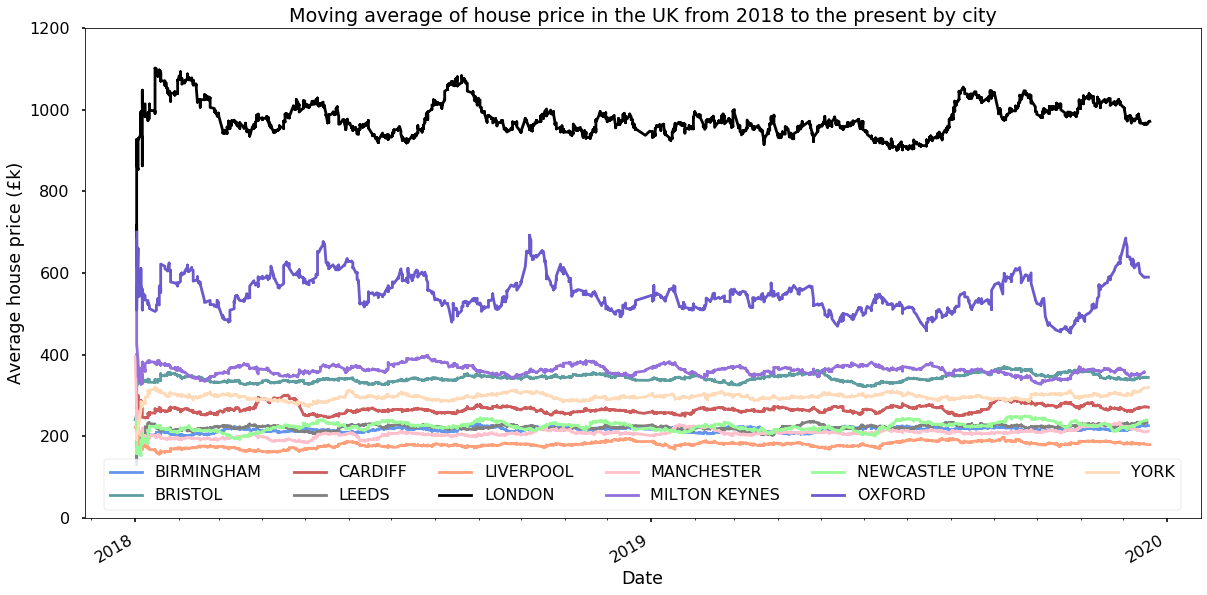

In [14]:
cities = df_time.town.unique() #find unique values for towns
cities = sorted(cities)
string_a = 'df_'
citiesdfs = [string_a+x for x in cities]  #generates names for dfs for each city
colour = ['cornflowerblue','cadetblue','indianred','gray','lightsalmon','black','pink','mediumpurple','palegreen','slateblue','peachpuff'] #define a list of 11 colours to differentiate the cities (matplotlib cycles normally)

fig2, ax2 = plt.subplots(figsize=(20,10))
for i,j,c in zip(citiesdfs,cities,colour):
    i = df_time.loc[df_time['town'] == j]
    i.set_index('deed_date', inplace = True)
    i['MA'] = i.price_paid.rolling('30d').mean() #find rolling average
    i = i.drop(['town','outcode','postcode_area','price_paid'],axis=1) # remove superfluous columns
    i = i.rename(columns={'MA':j})
    ax2.plot(i.index.values,i[j],label=j,color=c)

ax2.set(xlabel='Date',
       ylabel='Average house price (£k)',
       title='Moving average of house price in the UK from 2018 to the present by city',
       ylim=(0,1200)
      )

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(years_fmt)
ax2.xaxis.set_minor_locator(months)


fig2.autofmt_xdate()
plt.legend(ncol=6,
           loc='lower center',
#            fontsize='medium'
          )
# fig2.savefig("Figure2.png")
plt.show()

So, again we see that prices are relatively stable over this period, and we get a sense of the price differential between cities. London is unsurprisingly the most expensive, with an average price hovering about £1,000,000, while places like Liverpool, Manchester and Newcastle hover around the £200,000 mark

Now, let's get coordinates for each postcode. As the geocoders don't handle outcodes well, we have downloaded the coordinates for each postcode from <a href=https://www.ordnancesurvey.co.uk/opendatadownload/products.html>OS CodePoint</a>. Unfortunately, the location data are in Eastings/Northings rather than latitude/longitude, so we have to do some converting.

In [15]:
# !pip install pyproj
from pyproj import CRS #script for transforming from Easting/Northings to latitude/longitude
from pyproj import Transformer
crs = CRS.from_epsg(27700) #the CodePoint data uses eastings and northings data in the EPSG27700 format
crs2 = crs.geodetic_crs # this finds the EPSG to convert to for lat/long
transformer = Transformer.from_crs(crs,crs2)

In [16]:
postcode_areas = ['b','bs','cf','e','ec','l','ls','m','mk','n',
                  'ne','nw','ox','se','sw','w','wc','yo'] #these are the filenames of the location data 
                                                          #provided by CodePoint for the postcodes we are interested in
string_b = 'Postcode_data/Data/CSV/{}.csv'
paths = [string_b.format(x) for x in postcode_areas] #paths for individual postcode location data CSVs
codepointheaders = {0:'Postcode',1:'Positional_quality_indicator',2:'Eastings',3:'Northings',
                    4:'Country_code',5:'NHS_regional_HA_code',6:'NHS_HA_code',7:'Admin_county_code',
                    8:'Admin_district_code',9:'Admin_ward_code'} #Table headers as provided by CodePoint

latlong = pd.DataFrame(columns = ['outcode','Lat','Long']) #Create DF for latlong data

# This reads in the data in each individual csv from CodePoint, drops the columns we are not interested in,
# and converts to Latitude and Longitude
for i in paths:
    temp = pd.read_csv(i,header=None)
    temp = temp.rename(columns = codepointheaders)
    temp = temp.drop(['Positional_quality_indicator','Country_code',
                      'NHS_regional_HA_code','NHS_HA_code','Admin_county_code',
                      'Admin_district_code','Admin_ward_code'],axis=1) #remove useless columns
    temp["outcode"]=temp["Postcode"].apply(outcode)
    temp = temp.groupby('outcode').mean() #averaging the northings/eastings for each outcode
    temp = temp.reset_index()
    
    #use the transformer to obtain lat/long coords from the eastings/northings
    temp['Latlong']=temp[['Eastings','Northings']].apply (lambda row: transformer.transform(row.Eastings, row.Northings), axis=1) 
    temp[['Lat', 'Long']] = pd.DataFrame(temp['Latlong'].tolist(), index=temp.index)  #split the tuple into separate lat and long columns
    temp = temp.drop(['Eastings','Northings','Latlong'],axis=1) #drop the superfluous data
    latlong = pd.concat([latlong,temp])

latlong = latlong.reset_index(drop=True)
latlong.head()

,outcode,Lat,Long
0,B1,52.480,-1.908
1,B10,52.469,-1.851
2,B11,52.454,-1.857
3,B12,52.460,-1.882
4,B13,52.437,-1.878


Now we need to combine the price data with the location data. Let's get the average house price for each postcode.

In [17]:
price = df.drop(['deed_date','new_build','property_type','estate_type','street','district','county'],axis=1)
print(price.shape)
price.head()

(138755, 5)


,price_paid,postcode,town,outcode,postcode_area
0,460.0,OX1 1JS,OXFORD,OX1,OX
1,432.0,OX1 1RP,OXFORD,OX1,OX
2,435.0,OX1 1SU,OXFORD,OX1,OX
3,680.0,OX1 1SU,OXFORD,OX1,OX
4,485.0,OX1 1SU,OXFORD,OX1,OX


In [18]:
#gives average house price over the last 2 years
price_av = price.groupby(['outcode']).mean()
price_av = price_av.reset_index()
price_av.head()

,outcode,price_paid
0,B1,235.095
1,B10,141.626
2,B11,159.552
3,B12,154.345
4,B13,308.560


Now let's add in the lat/long data into our price data.

In [19]:
outcode_CP = latlong.outcode.values #create list of outcodes in the CodePoint data
latlong_CP = [] #initialize list for latitude and longitudes
for i in range(len(outcode_CP)):
    latlong_CP.append([latlong.loc[i,'Lat'],latlong.loc[i,'Long']])

loc_dict = dict(zip(outcode_CP,latlong_CP)) #create dictionary for lat/long values for each outcode

In [20]:
price_av['LatLong'] = price_av['outcode'].map(loc_dict) #map the appropriate locations on to the outcodes in price_av
price_av[['Lat','Long']] = price_av.LatLong.apply(pd.Series) #split the list column into separate lat and long columns
price_av = price_av.drop('LatLong',axis=1) #drop the list column
print(price_av.shape)
price_av.head()

(358, 4)


,outcode,price_paid,Lat,Long
0,B1,235.095,52.480,-1.908
1,B10,141.626,52.469,-1.851
2,B11,159.552,52.454,-1.857
3,B12,154.345,52.460,-1.882
4,B13,308.560,52.437,-1.878


Let's also add a 'town' column so that we can use the colours we used in our previous figure, using the same method.

In [21]:
OC_towns = price.drop(['price_paid','postcode','postcode_area'],axis=1)
OC_towns.drop_duplicates(inplace=True)
OC_towns.sort_values(by='outcode',axis=0,inplace=True)
OC_towns.reset_index(inplace=True,drop=True)
# OC_towns.head()

towns = OC_towns.town.values
outcodes = OC_towns.outcode.values
town_dict = dict(zip(outcodes,towns))

colour_dict = dict(zip(cities,colour))

price_av['town'] = price_av['outcode'].map(town_dict)
price_av['colour'] = price_av['town'].map(colour_dict)
price_av.head()

,outcode,price_paid,Lat,Long,town,colour
0,B1,235.095,52.480,-1.908,BIRMINGHAM,cornflowerblue
1,B10,141.626,52.469,-1.851,BIRMINGHAM,cornflowerblue
2,B11,159.552,52.454,-1.857,BIRMINGHAM,cornflowerblue
3,B12,154.345,52.460,-1.882,BIRMINGHAM,cornflowerblue
4,B13,308.560,52.437,-1.878,BIRMINGHAM,cornflowerblue


Let's quickly check to see if we are missing any lat/long values, as our outcodes come from different data sources.

In [22]:
null_data = price_av[price_av.isnull().any(axis=1)]
null_data

,outcode,price_paid,Lat,Long,town,colour
349,YO4,247.999,NaN,NaN,YORK,peachpuff
354,YO6,177.000,NaN,NaN,YORK,peachpuff


There are only 2 missing values. It appears that YO4 and YO6 are no longer in use, so let's remove them from the dataset.

In [23]:
price_av = price_av.dropna(axis=0,subset=['Lat'])
print(price_av.shape)

(356, 6)


Let's have a quick look to check if our outcodes have the correct coordinates.
#### Map 1 <a name = "map1"></a>

In [24]:
# !conda install -c conda-forge folium=0.5.0 --yes
import folium 

In [111]:
map_1 = folium.Map(location=[52.7,-1.0951],width = 500,height = 750,zoom_start = 6.5)
# add markers to map
for lat, lng, postcode in zip(price_av['Lat'], price_av['Long'], price_av['outcode']):
    label = '{}'.format(postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_1)

map_1

We can see we've got a pretty good spread of districts, although the ones around York and Newcastle do include quite a few rural districts, which we have to take into account when analyzing the results.

#### Find data on venues in each of these regions

Now that we have our districts correctly mapped, we can start looking at venues.

Here we will use foursquare to find stats on each area, and generate clusters that will allow us to identify areas in different cities that are similar to each other.

In [30]:
#Foursquare IDs hidden for sharing

In [31]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We will examine the top 100 venues in a radius of 500 m of each outcode centre. This is not ideal, as the outcodes are of highly variable size. However, unfortunately the datasets containing the areas of the outcodes are not publicly available, so this is a very rough approximation.

In [35]:
radius = 500
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['outcode', 
                  'outcode Lat', 
                  'outcode Long', 
                  'Venue', 
                  'Venue Lat', 
                  'Venue Long', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
UK_venues = getNearbyVenues(names=price_av['outcode'],
                                   latitudes=price_av['Lat'],
                                   longitudes=price_av['Long']
                                  )

B1
B10
B11
B12
B13
B14
B15
B16
B17
B18
B19
B20
B21
B23
B24
B25
B26
B27
B28
B29
B3
B30
B31
B32
B33
B34
B35
B36
B37
B38
B42
B43
B44
B45
B46
B47
B48
B5
B6
B7
B8
B9
BS1
BS10
BS11
BS13
BS14
BS15
BS16
BS2
BS20
BS3
BS30
BS31
BS32
BS34
BS35
BS36
BS37
BS39
BS4
BS40
BS41
BS48
BS49
BS5
BS6
BS7
BS8
BS9
CF10
CF11
CF14
CF15
CF23
CF24
CF3
CF5
E1
E10
E11
E12
E13
E14
E15
E16
E17
E18
E1W
E2
E20
E3
E4
E5
E6
E7
E8
E9
EC1M
EC1R
EC1V
EC1Y
L1
L10
L11
L12
L13
L14
L15
L16
L17
L18
L19
L20
L21
L22
L23
L24
L25
L26
L27
L28
L29
L3
L31
L32
L33
L36
L37
L38
L4
L5
L6
L7
L8
L9
LS10
LS11
LS12
LS13
LS14
LS15
LS16
LS17
LS18
LS19
LS2
LS20
LS25
LS26
LS27
LS3
LS4
LS5
LS6
LS7
LS8
LS9
M1
M11
M12
M13
M14
M15
M16
M18
M19
M20
M21
M22
M23
M24
M25
M26
M27
M28
M29
M3
M30
M31
M32
M34
M35
M38
M4
M40
M41
M43
M44
M45
M46
M8
M9
MK1
MK10
MK11
MK12
MK13
MK14
MK15
MK17
MK19
MK2
MK3
MK4
MK5
MK6
MK7
MK8
MK9
N1
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N2
N20
N21
N22
N3
N4
N5
N6
N7
N8
N9
NE1
NE12
NE13
NE15
NE16
NE17
NE18
NE19
NE2
NE20
NE27
NE3
NE

In [37]:
print(UK_venues.shape)
UK_venues.head() #see how many results we got

(7444, 7)


,outcode,outcode Lat,outcode Long,Venue,Venue Lat,Venue Long,Venue Category
0,B1,52.48,-1.908,Symphony Hall,52.479,-1.910,Concert Hall
1,B1,52.48,-1.908,Hyatt Regency Birmingham,52.478,-1.909,Hotel
2,B1,52.48,-1.908,Canalside Walk,52.481,-1.909,Trail
3,B1,52.48,-1.908,The Rep Theatre,52.479,-1.909,Theater
4,B1,52.48,-1.908,Birmingham Museum & Art Gallery,52.480,-1.904,History Museum


Now we have our data in an appropriate format, let's perform some analysis to find similar areas across the country.

In [38]:
UK_venues.groupby('outcode').count() #see how many venues there are for each neighbourhood group

,outcode Lat,outcode Long,Venue,Venue Lat,Venue Long,Venue Category
outcode,,,,,,
B1,82,82,82,82,82,82
B10,5,5,5,5,5,5
B11,4,4,4,4,4,4
B12,9,9,9,9,9,9
B13,1,1,1,1,1,1
B14,5,5,5,5,5,5
B15,6,6,6,6,6,6
B16,4,4,4,4,4,4
B17,8,8,8,8,8,8


We can see there is a wide variety of number of venues in each postcode - this should help the clustering to separate dense districts from more sparse districts.

Now we will analyze the districts to find the most common types of venue in each area.

### Methodology <a name="methodology"></a>

In this project we wish to create a tool to allow people living in more expensive postcodes to identify less expensive postcodes that offer a similar living experience (i.e. types of venues nearby).

We have first of all found the **price and location data** required for the analysis, and also found the **types of venues** within a 500 m radius of the centre of each area.

We will now use **K-means clustering** to group the postcode districts based on the **types of nearby venues**. 

Finally, we will **create a tool** that takes an outcode as an input and produces a graph detailing the cheapest areas in that outcode's cluster, and locates them on a map. This will provide the user with a good starting point for exploration for looking for a property.

### Analysis <a name="analysis"></a>

First of all, let's get our clusters.

In [39]:
# one hot encoding
UK_onehot = pd.get_dummies(UK_venues[['Venue Category']], prefix="", prefix_sep="")

# add outcode column back to dataframe
UK_onehot['outcode'] = UK_venues['outcode'] 

# move outcode column to the first column
fixed_columns = [UK_onehot.columns[-1]] + list(UK_onehot.columns[:-1])
UK_onehot = UK_onehot[fixed_columns]

# group rows by neighbourhood and take the mean of the frequency of occurrence of each category
UK_grouped = UK_onehot.groupby('outcode').mean().reset_index()
UK_grouped.head()

,outcode,ATM,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Laser Tag,Latin American Restaurant,Leather Goods Store,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Medical School,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoor Supply Store,Outlet Store,Pakistani Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Pawn Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Piercing Parlor,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Post Office,Pub,Racetrack,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,

In [56]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In order to choose the right number of clusters, we will use the silhouette score method to choose K. We want a relatively large number of clusters, to narrow down the number of postcodes in each area to a useful amount. 

In [63]:
range_n_clusters = list(range(20, 60))          # range of clusters to try
UK_grouped_clustering = UK_grouped.drop('outcode', 1)  # input data
best_clusters = 0                       # initialize best clusters and silh variables
previous_silh_avg = 0.0

# use the silhouette score to find the best number of clusters to use
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(UK_grouped_clustering)
    silhouette_avg = silhouette_score(UK_grouped_clustering, cluster_labels)
    if silhouette_avg > previous_silh_avg:
        previous_silh_avg = silhouette_avg
        best_clusters = n_clusters

# run k-means clustering
kmeans = KMeans(n_clusters=best_clusters, random_state=0).fit(UK_grouped_clustering)

# add clustering labels
clus = pd.DataFrame(columns=['outcode'])
clus['outcode'] = UK_grouped['outcode']
clus.insert(0,'Cluster_Labels',kmeans.labels_)



# merge the cluster with the original price data to add clusters for each Postcode
UK_merged = price_av
UK_merged = UK_merged.join(clus.set_index('outcode'), on='outcode')
UK_merged.Cluster_Labels = UK_merged.Cluster_Labels.fillna(0.0).astype(int) 
print('There are',best_clusters,'clusters')
UK_merged.head()     

There are 32 clusters


,outcode,price_paid,Lat,Long,town,colour,Cluster_Labels
0,B1,235.095,52.480,-1.908,BIRMINGHAM,cornflowerblue,2
1,B10,141.626,52.469,-1.851,BIRMINGHAM,cornflowerblue,2
2,B11,159.552,52.454,-1.857,BIRMINGHAM,cornflowerblue,6
3,B12,154.345,52.460,-1.882,BIRMINGHAM,cornflowerblue,24
4,B13,308.560,52.437,-1.878,BIRMINGHAM,cornflowerblue,9


Now we have our clusters, let's visualize them:

#### Map 2 <a name = "map2"></a>

In [110]:
# create map
map_2 = folium.Map(location=[52.7,-1.0951],width = 500,height = 750,zoom_start = 6.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(UK_merged['Lat'], UK_merged['Long'], UK_merged['outcode'], UK_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_2)
       
map_2

This is looking good! Now let's create our interactive tool.

We are going to create an interactive data explorer, where the user can put in their outcode and find the least expensive districts in the chosen cities that are in the same cluster as their outcode.

First we define a function that takes an outcode as an argument and produces a graph of the 10 lowest-price districts in that outcode's clusters, and maps those clusters.

In [106]:
def lowest_price_districts(Outcode):
    A = Outcode
    try:
        ## find the cluster for the input outcode
        cluster = UK_merged.loc[UK_merged['outcode']==A]
        cluster = cluster['Cluster_Labels'].values[0]

        ## get the lowest 10 priced districts that share a cluster with the input outcode
        temp = UK_merged[UK_merged['Cluster_Labels']==cluster]
        temp.sort_values(by='price_paid',inplace=True)
        temp = temp.reset_index(drop=True)
        temp = temp.head(10)

        num_of_bars = temp.index.values
        outcodes = temp.outcode.values
        towns = temp.town.values
        colours = temp.colour.values
        prices = temp.price_paid.values #values to plot

        ##plot the results
        fig3, ax3 = plt.subplots(figsize=(20,5))

        y_pos=np.arange(len(num_of_bars)) #get the y positions for the bars

        ax3.barh(y_pos,prices,color=colours)

        ax3.set(xlabel='Average house price (£k)',
                ylabel='Outcode',
                title='{} least expensive districts that have similar venue types to {}'.format(len(num_of_bars),A),
                ylim=(-1,len(num_of_bars)),
                xlim=(0,max(prices)+max(prices)/5) #scale x-axis to the bar length
               )
        ax3.set_yticklabels(['']*len(num_of_bars))#removes y axis labels

        plt.tick_params(
            axis='y',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False        # ticks along the top edge are off
            ) 

        for rect,i,j,k in zip(ax3.patches,outcodes,num_of_bars,towns):
            # Get X and Y placement of label from rect.
            label_ypos = rect.get_y()+ rect.get_height() / 2
            label_xpos = rect.get_width() + max(prices)/50
            fntsz = 'large'



            label = '{}, {}'.format(i,k) 
            ax3.annotate(label,
                         xy=(label_xpos,label_ypos),
                         color='black',
                         fontsize = fntsz,
                         ha='left',
                         va='center'
                        )
        # fig3.savefig("Figure3.png")
        plt.show()
        
        
        map_3 = folium.Map(location=[52.7,-1.0951],width = 500,height = 750,zoom_start = 6.5)

        # add markers to map
        for lat, lng, postcode in zip(temp['Lat'], temp['Long'], temp['outcode']):
            label = '{}'.format(postcode)
            label = folium.Popup(label, parse_html=True)
            folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(map_3)
            
        map_3.fit_bounds([50.597306, -4.337250],[55.066851, -1.180122])
        display(map_3)
        
    except:
        print("Postcode outcode not found")

Then we can use ipywidgets to create a basic lookup tool!

#### Final tool <a name = "tool"></a>

In [107]:
## use ipywidgets to create a basic lookup tool
interact(lowest_price_districts, Outcode=price_av['outcode'])

interactive(children=(Dropdown(description='Outcode', options=('B1', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15',…

<function __main__.lowest_price_districts(Outcode)>

And there we are! An interactive tool that will suggest areas of the UK to live that might offer cheaper house prices for similar access to amenities

### Results and Discussion <a name = "results"></a>

Our initial exploration of the data confirmed the premise of the analysis, i.e. more southern cities are significantly more expensive places to buy houses [see Figure 2](#fig2). While most cities included in the analysis had an average house price of £200,000 to £400,000, Oxford was a notable outlier at £600,000 while London was at a whopping £1,000,000. This clearly demonstrates the need of young residents in these more expensive places to be able to find more affordable homes, without sacrificing access to amenities.

Using the tool we have generated, users can input their postcode district and the tool will suggest 'similar' areas with  potentially lower house prices. For example, putting in 'OX1', the postcode district for central Oxford, will result in a suggestion of areas of Manchester, Birmingham, Liverpool, Bristol and York. For the purposes of this project, we can consider this a good proof of concept.

A small selection of cities were used for this exercise to keep the dataset to a manageable size. Additionally, the postcodes used were chosen to focus on metropolitan areas while keeping a good spread between North and South. In order to broaden the utility of this tool, we would ideally include all postcode areas in the UK. 

This would, however, introduce a secondary problem - postcodes are of highly variable size, so the number of venues in each district would have to be scaled to the area. Unfortunately, the shape and size of each postcode is [not freely available](https://www.ordnancesurvey.co.uk/business-government/products/code-point-polygons). Future iterations of this tool could involve the purchase of these data in order to provide better clustering and therefore more accurate recommendations.

Another improvement that could be made is to further categorise the price data by property type, so users could search for e.g. semi-detached houses.

### Conclusion <a name = "conclusion"></a>

While this tool can of course not provide the perfect area to move to, it can provide users with some appropriate suggestions that they can further investigate. By narrowing the options, it helps our user find their perfect (affordable) house.

### Appendices <a name="appendices"></a>

#### Appendix 1 - SPARQL query used for house price data <a name="App1"></a>

This query was repeated for each of the cities in the analysis.

```
PREFIX  xsd:  <http://www.w3.org/2001/XMLSchema#>
PREFIX  text: <http://jena.apache.org/text#>
PREFIX  ppd:  <http://landregistry.data.gov.uk/def/ppi/>
PREFIX  lrcommon: <http://landregistry.data.gov.uk/def/common/>

SELECT  ?item ?ppd_propertyAddress ?ppd_transactionCategory ?ppd_transactionDate ?ppd_estateType ?ppd_hasTransaction ?ppd_pricePaid ?ppd_transactionId ?ppd_newBuild ?ppd_propertyAddressCounty ?ppd_propertyAddressDistrict ?ppd_propertyAddressLocality ?ppd_propertyAddressPaon ?ppd_propertyAddressPostcode ?ppd_propertyAddressSaon ?ppd_propertyAddressStreet ?ppd_propertyAddressTown ?ppd_propertyType ?ppd_recordStatus
WHERE
  { { ?ppd_propertyAddress
                text:query            ( lrcommon:town "( CITY )" 3000000 ) .
      ?item     ppd:propertyAddress   ?ppd_propertyAddress ;
                ppd:estateType        lrcommon:freehold ;
                ppd:transactionCategory  ppd:standardPricePaidTransaction ;
                ppd:transactionDate   ?ppd_transactionDate ;
                ppd:hasTransaction    ?ppd_hasTransaction ;
                ppd:pricePaid         ?ppd_pricePaid ;
                ppd:transactionId     ?ppd_transactionId
      FILTER ( ?ppd_transactionDate >= "2018-01-01"^^xsd:date )
      FILTER ( ?ppd_transactionDate <= "2020-02-22"^^xsd:date )
    }
    OPTIONAL
      { ?item  ppd:newBuild  ?ppd_newBuild }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:county  ?ppd_propertyAddressCounty
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:district  ?ppd_propertyAddressDistrict
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:locality  ?ppd_propertyAddressLocality
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:paon  ?ppd_propertyAddressPaon
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:postcode  ?ppd_propertyAddressPostcode
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:saon  ?ppd_propertyAddressSaon
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:street  ?ppd_propertyAddressStreet
      }
    OPTIONAL
      { ?ppd_propertyAddress
                  lrcommon:town  ?ppd_propertyAddressTown
      }
    OPTIONAL
      { ?item  ppd:propertyType  ?ppd_propertyType }
    OPTIONAL
      { ?item  ppd:recordStatus  ?ppd_recordStatus }
    BIND(lrcommon:freehold AS ?ppd_estateType)
    BIND(ppd:standardPricePaidTransaction AS ?ppd_transactionCategory)
  }
  ```

#### Appendix 2 - Fun code snippets I didn't end up using

In [ ]:
#gives average price of each type of property (Terrace, Detached, Semi-Detached, Flat) in each outcode
pricetype = price.groupby(['outcode','property_type']).mean() 
pricetype = pricetype.reset_index() 

In [ ]:
# here we create a list of x-values for the labels that alternate distance from bar end to avoid overlapping, if there are a lot of districts in the cluster
    if len(prices)>30:
        a = [i+130 for i in prices[::2]]
        b = prices[1::2]
        xpos = [None]*(len(a)+len(b))
        xpos[::2] = a
        xpos[1::2] = b
        label_xpos = xpos[j]+30
        fntsz = 'medium'

In [ ]:
## create postcode entry widget
pricefinder = widgets.Text(
    value='',
    placeholder='Enter your postcode district',
    description='Postcode district:',
    disabled=False
)

In [113]:
## Using a free text box instead of a dropdown for the widget
interact(lowest_price_districts, Outcode='')

interactive(children=(Text(value='', description='Outcode'), Output()), _dom_classes=('widget-interact',))

<function __main__.lowest_price_districts(Outcode)>